In [4]:
from sogym.env import sogym
import warnings
import dreamerv3
from dreamerv3 import embodied
from dreamerv3 import agent as agt
from embodied.envs import from_gym


In [5]:
from sogym.env import sogym
import warnings
import dreamerv3
from dreamerv3 import embodied
warnings.filterwarnings('ignore', '.*truncated to dtype int32.*')

# See configs.yaml for all options.
config = embodied.Config(dreamerv3.configs['defaults'])
config = config.update(dreamerv3.configs['small'])
config = config.update({
    'run.logdir': 'logdir/run1',
    'run.train_ratio': 64,
    'run.log_every': 30,  # Seconds
    'batch_size': 16,
    'encoder.mlp_keys': ['conditions','volume','design_variables','n_steps_left'],
    'decoder.mlp_keys':  ['conditions','volume','design_variables','n_steps_left'],
    'encoder.cnn_keys': '$^',
    'decoder.cnn_keys': '$^',
    'jax.platform': 'cpu',
})

logdir = embodied.Path(config.run.logdir)
step = embodied.Counter()
logger = embodied.Logger(step, [
    embodied.logger.TerminalOutput(),
    embodied.logger.JSONLOutput(logdir, 'metrics.jsonl'),
    embodied.logger.TensorBoardOutput(logdir),
    # embodied.logger.WandBOutput(logdir.name, config),
    # embodied.logger.MLFlowOutput(logdir.name),
])

import crafter
from embodied.envs import from_gym
env = sogym(nelx=100,nely=50,mode='train',observation_type='dense')  # Replace this with your Gym env.
env = from_gym.FromGym(env)

agent = agt.Agent(env.obs_space, env.act_space, step, config)
checkpoint = embodied.Checkpoint()
checkpoint.agent = agent
checkpoint.load('logdir/run1/checkpoint.pkl', keys=['agent'])
obs=env._env.reset()
obs=env._obs(obs, 0.0, is_first=True)
obs = {k: embodied.convert(v) for k, v in obs.items()}

act, state = agent.policy(obs, mode='eval')

Encoder CNN shapes: {}
Encoder MLP shapes: {'conditions': (9,), 'design_variables': (48,), 'n_steps_left': (1,), 'volume': (1,)}
Decoder CNN shapes: {}
Decoder MLP shapes: {'conditions': (9,), 'design_variables': (48,), 'n_steps_left': (1,), 'volume': (1,)}
JAX devices (1): [CpuDevice(id=0)]
Policy device: TFRT_CPU_0
Train devices: TFRT_CPU_0
Tracing train function.
Optimizer model_opt has 16,541,499 variables.
Optimizer actor_opt has 1,056,780 variables.
Optimizer critic_opt has 1,181,439 variables.
Loading checkpoint: logdir/run1/checkpoint.pkl
Loading checkpoint with step 8755024
Loaded checkpoint from 8283 seconds ago.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /Users/thomasrochefort/opt/anaconda3/envs/dreamer/lib/python3.8/site-packages/jax/core.py:1440   │
│ in _len                                                                                          │
│                                                                                                  │
│   1437                                                                                           │
│   1438   def _len(self, ignored_tracer):                                                         │
│   1439 │   try:                                                                                  │
│ ❱ 1440 │     return self.shape[0]                                                                │
│   1441 │   except IndexError as err:                                                             │
│   1442 │     raise TypeError("len() of unsized object") from err  # same as numpy error          │
│   1443                                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
IndexError: tuple index out of range

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│   42 obs=env._obs(obs, 0.0, is_first=True)                                                       │
│   43 obs = {k: embodied.convert(v) for k, v in obs.items()}                                      │
│   44                                                                                             │
│ ❱ 45 act, state = agent.policy(obs, mode='eval')                                                 │
│   46                                                                                             │
│                                                                                                  │
│ /Users/thomasrochefort/opt/anaconda3/envs/dreamer/lib/python3.8/site-packages/dreamerv3/jaxagent │
│ .py:109 in policy                                                                                │
│                                                                                                  │
│   106 │   rng = self._next_rngs()                                                                │
│   107 │   varibs = self.varibs if self.single_device else self.policy_varibs                     │
│   108 │   if state is None:                                                                      │
│ ❱ 109 │     state, _ = self._init_policy(varibs, rng, obs['is_first'])                           │
│   110 │   else:                                                                                  │
│   111 │     state = tree_map(                                                                    │
│   112 │   │     jnp.asarray, state, is_leaf=lambda x: isinstance(x, list))                       │
│                                                                                                  │
│ /Users/thomasrochefort/opt/anaconda3/envs/dreamer/lib/python3.8/site-packages/dreamerv3/ninjax.p │
│ y:197 in wrapper                                                                                 │
│                                                                                                  │
│   194 │   statics = tuple(sorted([(k, v) for k, v in kw.items() if k in static]))                │
│   195 │   kw = {k: v for k, v in kw.items() if k not in static}                                  │
│   196 │   if not hasattr(wrapper, 'keys'):                                                       │
│ ❱ 197 │     created = init(statics, rng, *args, **kw

In [6]:
driver = embodied.Driver(env)
driver.on_episode(lambda ep, worker: per_episode(ep))
driver.on_step(lambda tran, _: step.increment())
policy = lambda *args: agent.policy(*args, mode='eval')

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│ ❱ 1 driver = embodied.Driver(env)                                                                │
│   2 driver.on_episode(lambda ep, worker: per_episode(ep))                                        │
│   3 driver.on_step(lambda tran, _: step.increment())                                             │
│   4 policy = lambda *args: agent.policy(*args, mode='eval')                                      │
│                                                                                                  │
│ /Users/thomasrochefort/opt/anaconda3/envs/dreamer/lib/python3.8/site-packages/dreamerv3/embodied │
│ /core/driver.py:18 in __init__                                                                   │
│                                                                                                  │
│   15   }                                                                                         │
│   16                                                                                             │
│   17   def __init__(self, env, **kwargs):                                                        │
│ ❱ 18 │   assert len(env) > 0                                                                     │
│   19 │   self._env = env                                                                         │
│   20 │   self._kwargs = kwargs                                                                   │
│   21 │   self._on_steps = []                                                                     │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AssertionError

In [80]:
driver.reset()
driver._state

In [7]:
env = sogym(nelx=100,nely=50,mode='train',observation_type='dense')  # Replace this with your Gym env.
env = from_gym.FromGym(env)
env._obs

<bound method FromGym._obs of FromGym(len=0, obs_space={'conditions': Space(dtype=float32, shape=(9,), low=-1.0, high=1.0), 'design_variables': Space(dtype=float32, shape=(48,), low=-3.1415927410125732, high=3.1415927410125732), 'n_steps_left': Space(dtype=float32, shape=(1,), low=0.0, high=1.0), 'volume': Space(dtype=float32, shape=(1,), low=0.0, high=1.0), 'reward': Space(dtype=float32, shape=(), low=-inf, high=inf), 'is_first': Space(dtype=bool, shape=(), low=False, high=True), 'is_last': Space(dtype=bool, shape=(), low=False, high=True), 'is_terminal': Space(dtype=bool, shape=(), low=False, high=True)}, act_space={'action': Space(dtype=float32, shape=(6,), low=-1.0, high=1.0), 'reset': Space(dtype=bool, shape=(), low=False, high=True)})>

In [11]:
env._env.reset()


{'conditions': array([ 0.5882353 ,  0.990099  ,  0.        ,  0.        ,  0.98039216,
         0.        ,  0.3       ,  0.57357645, -0.81915206], dtype=float32),
 'design_variables': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'volume': array([0.], dtype=float32),
 'n_steps_left': array([1.], dtype=float32)}

In [12]:
env._env.Phi


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [65]:
obs=env._env.reset()

In [66]:
env._obs(obs, 0.0, is_first=True)

{'conditions': array([ 0.64705884,  0.        ,  0.        ,  0.990099  ,  0.98039216,
         0.990099  ,  0.3       ,  0.57357645, -0.81915206], dtype=float32),
 'design_variables': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 'volume': array([0.], dtype=float32),
 'n_steps_left': array([1.], dtype=float32),
 'reward': 0.0,
 'is_first': True,
 'is_last': False,
 'is_terminal': False}

In [145]:
env = sogym(nelx=100,nely=50,mode='train',observation_type='dense')  # Replace this with your Gym env.
env = from_gym.FromGym(env)
env = dreamerv3.wrap_env(env, config)
env = embodied.BatchEnv([env], parallel=False)
driver = embodied.Driver(env)
driver.on_step(lambda tran, _: step.increment())

In [146]:
checkpoint = embodied.Checkpoint()
checkpoint.agent = agent
checkpoint.load('logdir/run1/checkpoint.pkl', keys=['agent'])

print('Start evaluation loop.')
policy = lambda *args: agent.policy(*args, mode='eval')
driver(policy, steps=1)

Loading checkpoint: logdir/run1/checkpoint.pkl
Loading checkpoint with step 8755024
Loaded checkpoint from 9364 seconds ago.
Start evaluation loop.


In [174]:
driver.reset()

(5151, 8)


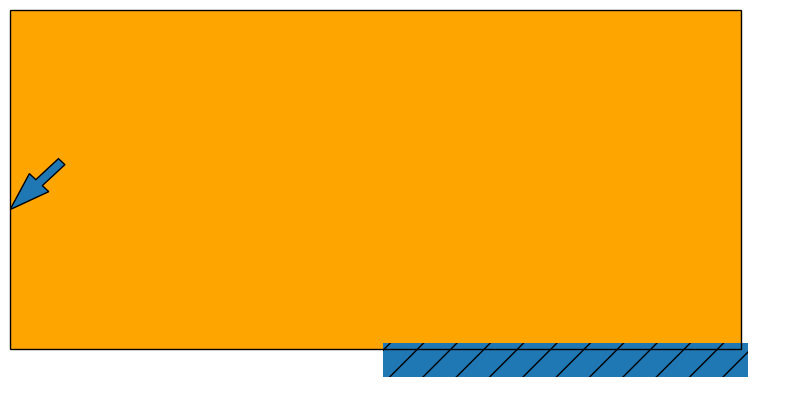

In [184]:

driver(policy, steps=1)
print(driver._env._envs[0]._env.Phi.shape)
driver._env._envs[0]._env.plot(train_viz=False)